In [2]:
def image_to_camera_frame(pose3d_image_frame, box, camera, rootIdx, root_depth):
    rectangle_3d_size = 2000.0
    ratio = (box[2] - box[0] + 1) / rectangle_3d_size
    pose3d_image_frame = pose3d_image_frame.copy()
    pose3d_image_frame[:, 2] = pose3d_image_frame[:, 2] / ratio + root_depth

    cx, cy, fx, fy = camera['cx'], camera['cy'], camera['fx'], camera['fy']
    pose3d_image_frame[:, 0] = (pose3d_image_frame[:, 0] - cx) / fx
    pose3d_image_frame[:, 1] = (pose3d_image_frame[:, 1] - cy) / fy
    pose3d_image_frame[:, 0] *= pose3d_image_frame[:, 2]
    pose3d_image_frame[:, 1] *= pose3d_image_frame[:, 2]
    return pose3d_image_frame

PROIEZIONE 3D -> 2D
[[543.67276633 425.48333455]
 [517.37381077 427.23362551]
 [514.33806441 507.74901218]
 [416.99263244 538.85980441]
 [570.83417746 423.91691123]
 [571.36960939 508.88639208]
 [594.32732572 587.36067462]
 [545.15173235 375.62924356]
 [542.54968782 316.55451927]
 [547.78480281 295.31228654]
 [541.8216616  274.43899133]
 [514.72818575 332.82583603]
 [498.46454883 384.72286522]
 [502.03184829 423.85341044]
 [569.08039594 333.85325308]
 [595.15898238 386.50235952]
 [611.86625875 422.65989445]]


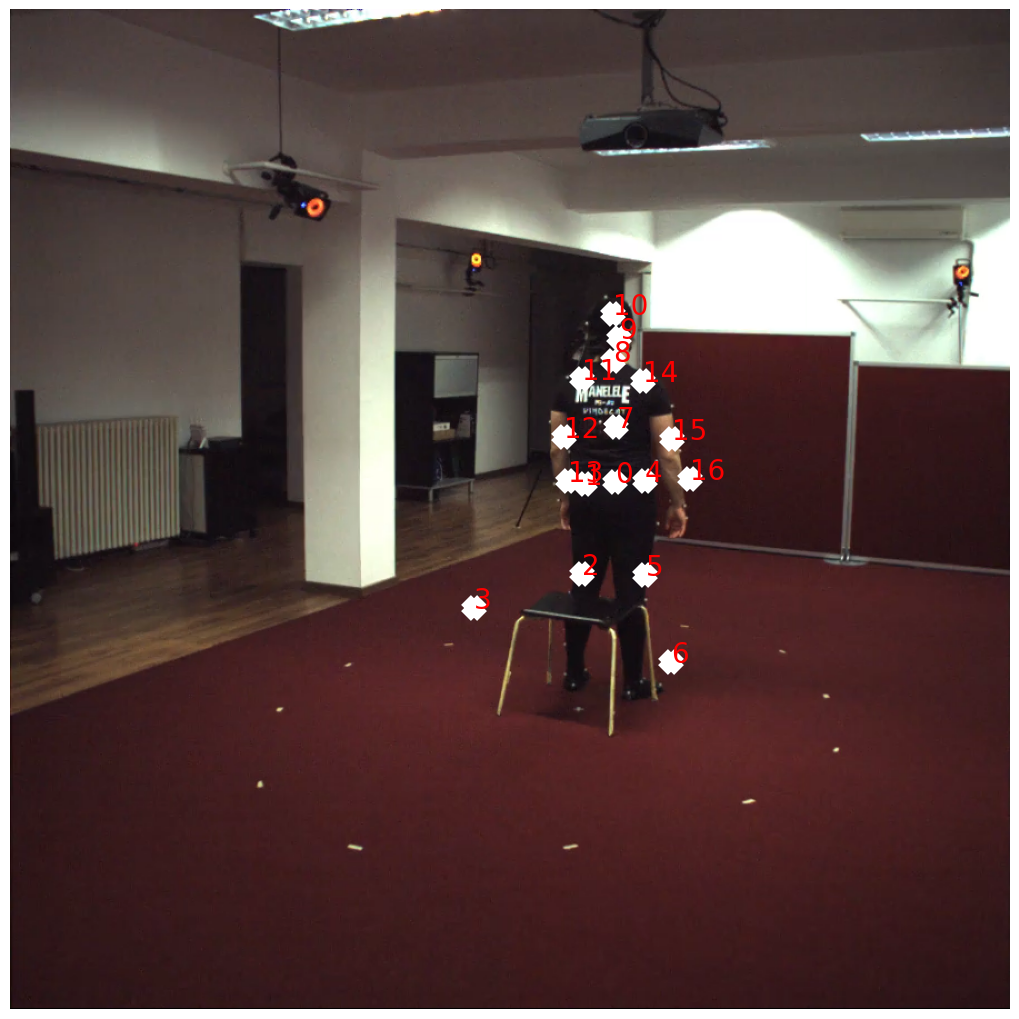

In [3]:
import sys
import numpy as np

sys.path.append('..')
from util.dataset_util import project_3d_to_2d, plot_over_image, read_data, load_data_from_pickle

data_root = '/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/dataset'
data_pred_path = '/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/experiment/test3/result.pkl'  # prediction file to be submitted; replace this with your prediction

subset = 'test' # select from ['train']
subj_name = 's01_v' # subject names for 'train' subset
action_name = '147'# action names
camera_name = '58860488' # select from ['50591643', '58860488', '60457274', '65906101']
 # path to the parent directory (contains test/ meta/)
dataset_name = 'humansc3d'

frames, j3ds, cam_params, _, _, annotations = read_data(data_root, 
                                                                            dataset_name, 
                                                                             subset, 
                                                                             subj_name, 
                                                                             action_name, 
                                                                             camera_name)
# data = load_data_from_pickle(data_pred_path)
# print(j3ds.shape)

# frame_id = annotations[action_name]['fr_id']
# j3d = j3ds[0]
R = cam_params['extrinsics']['R']
T = cam_params['extrinsics']['T']

import os
import pickle

DATAITEM_GT_PATH = os.path.join("/Users/andreaongaro/Documents/Documenti Andrea Ongaro/Magistrale/Torino/Corsi/2_ANNO/ComputerVision/Project/lcn-pose/dataset/humansc3d_test.pkl")
dataitem_gt = []
with open(DATAITEM_GT_PATH, 'rb') as f:
    dataitem_gt = pickle.load(f)


with open(data_pred_path, 'rb') as f:
    preds = pickle.load(f)['result']  # [N, 17, 3]

preds = np.reshape(preds, (-1, 17, 3))

idx = int(action_name) - 139
pred = preds[idx]  # [17, 3]
pred = image_to_camera_frame(pose3d_image_frame=pred, box=dataitem_gt[idx]['box'],
            camera=dataitem_gt[idx]['camera_param'], rootIdx=0,
            root_depth=dataitem_gt[idx]['root_depth'])

#Conversione 
j3d_in_camera = np.matmul(np.array(pred) - cam_params['extrinsics']['T'], np.transpose(cam_params['extrinsics']['R']))
pred = j3d_in_camera

frame = frames[0]
j2d_camera = project_3d_to_2d(j3d_in_camera, cam_params['intrinsics_w_distortion'], 'w_distortion')
print("PROIEZIONE 3D -> 2D")
print(j2d_camera)
plot_over_image(frame, j2d_camera, with_ids=True, with_limbs=False)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


/var/folders/sk/1sq5yr197f1bp_t0ddg91ynw0000gn/T/ipykernel_1961/1688740166.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


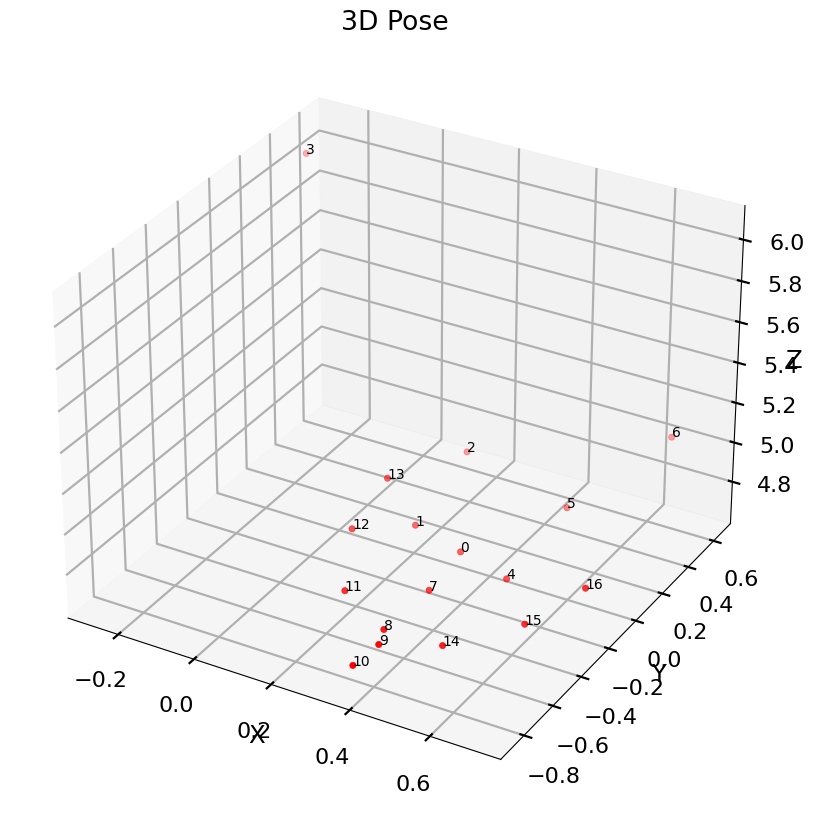

In [ ]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100)
z = np.linspace(-100, 100, 100)
X, Y, Z = np.meshgrid(x, y, z)

j3d_in_camera = np.array(pred)
ax.scatter3D(j3d_in_camera[:,0], j3d_in_camera[:,1], j3d_in_camera[:,2], color='red')

#give the labels to each point
for x, y, z, label in zip(j3d_in_camera[:,0], j3d_in_camera[:,1], j3d_in_camera[:,2], [ str(x) for x in range(17)]):
    ax.text(x, y, z, label)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pose')


plt.show()